# DEEP LEARNING IN COMPUTER VISION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

## Requirements

The experiments should be conducted for 2 data sets selected from the following catalogs: *animals*, *flowers*, *leaves*. The images belonging to these sets should differ in terms of color variability and the size of the objects presented in the images.

## Importing libraries

In [ ]:
from tensorflow.keras.layers import (Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import cv2, os, warnings, numpy as np, matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Setting the working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preparation

In [ ]:
# Loading the dataset
folder_path1 = "/content/drive/MyDrive/son/dog/train"
image_arrays = []
for filename in os.listdir(folder_path1):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(folder_path1, filename)
        img = cv2.imread(img_path)  # BGR order
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
        img = cv2.resize(img, (224, 224))
        image_arrays.append(img.astype(np.uint8))
x_train = np.stack(image_arrays, axis=0)  # shape: (N, H, W, 3)
print(x_train.shape, x_train.dtype)

folder_path2 = "/content/drive/MyDrive/son/dog/test"
image_arrays = []
for filename in os.listdir(folder_path2):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(folder_path2, filename)
        img = cv2.imread(img_path)  # BGR order
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
        img = cv2.resize(img, (224, 224))
        image_arrays.append(img.astype(np.uint8))
x_test = np.stack(image_arrays, axis=0)  # shape: (N, H, W, 3)
print(x_test.shape, x_test.dtype)

# Converting an image to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Entering image dimensions
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

(500, 224, 224, 3) uint8
(50, 224, 224, 3) uint8


## Colorful input images

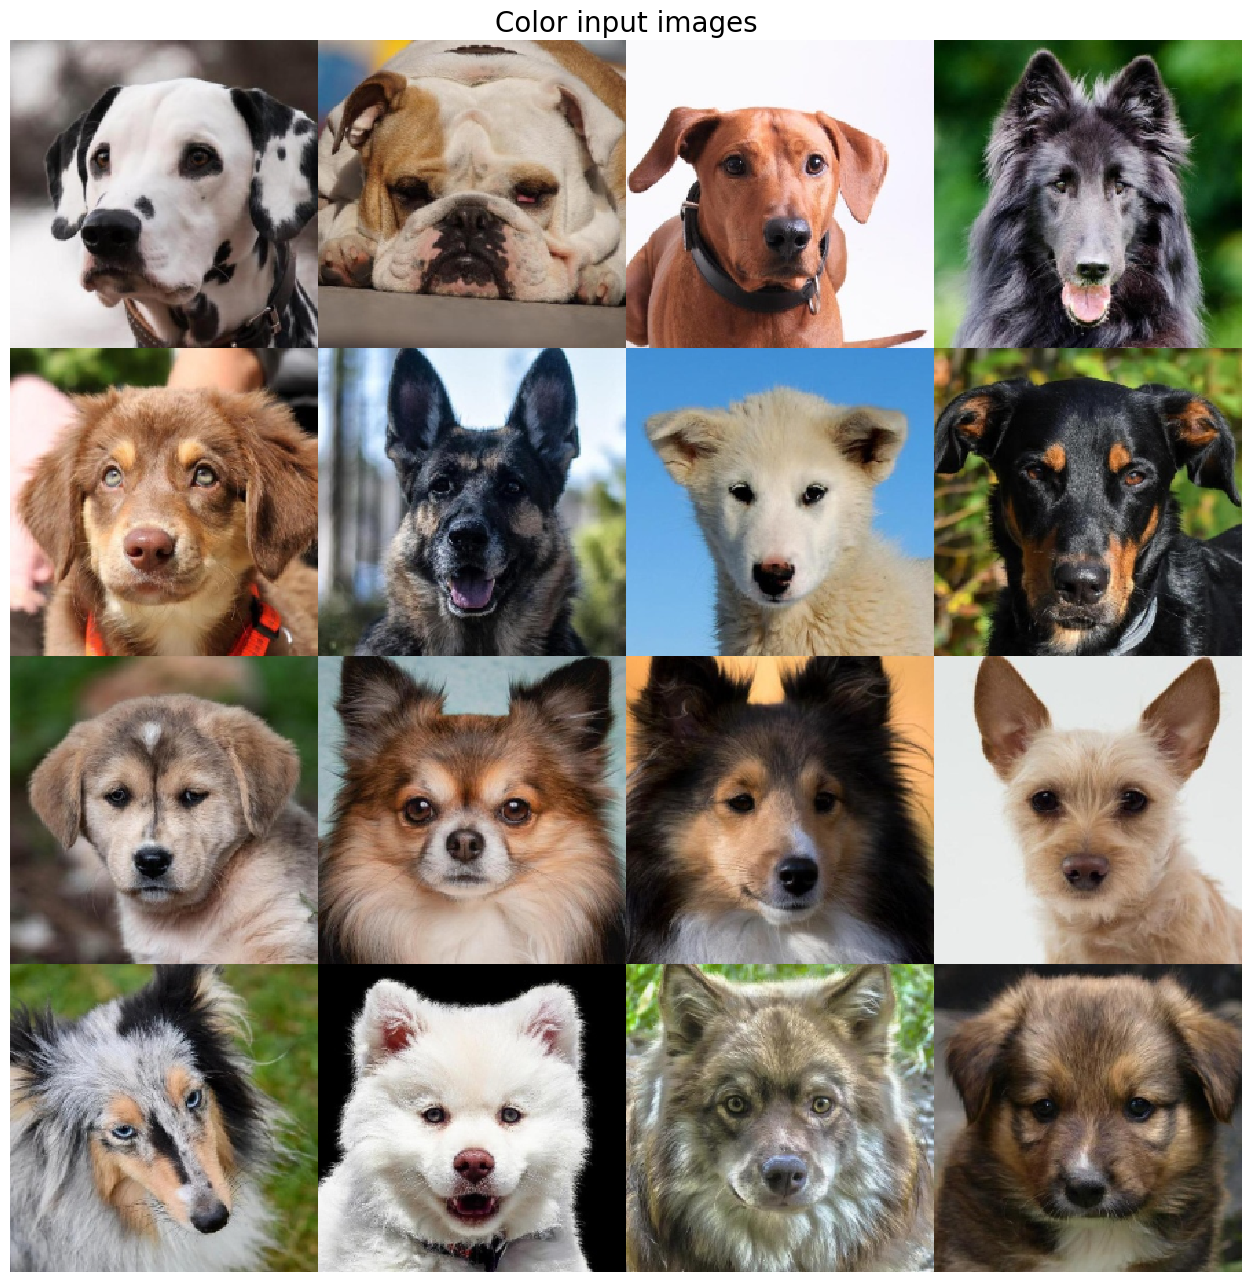

In [ ]:
imgs = x_test[:16]
imgs = imgs.reshape((4, 4, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.title('Color input images', fontsize=20)
plt.imshow(imgs, interpolation='none')
plt.savefig('Color input images.png')
plt.show()

## Conversion of training and test images to grayscale

In [ ]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

## Gray input images

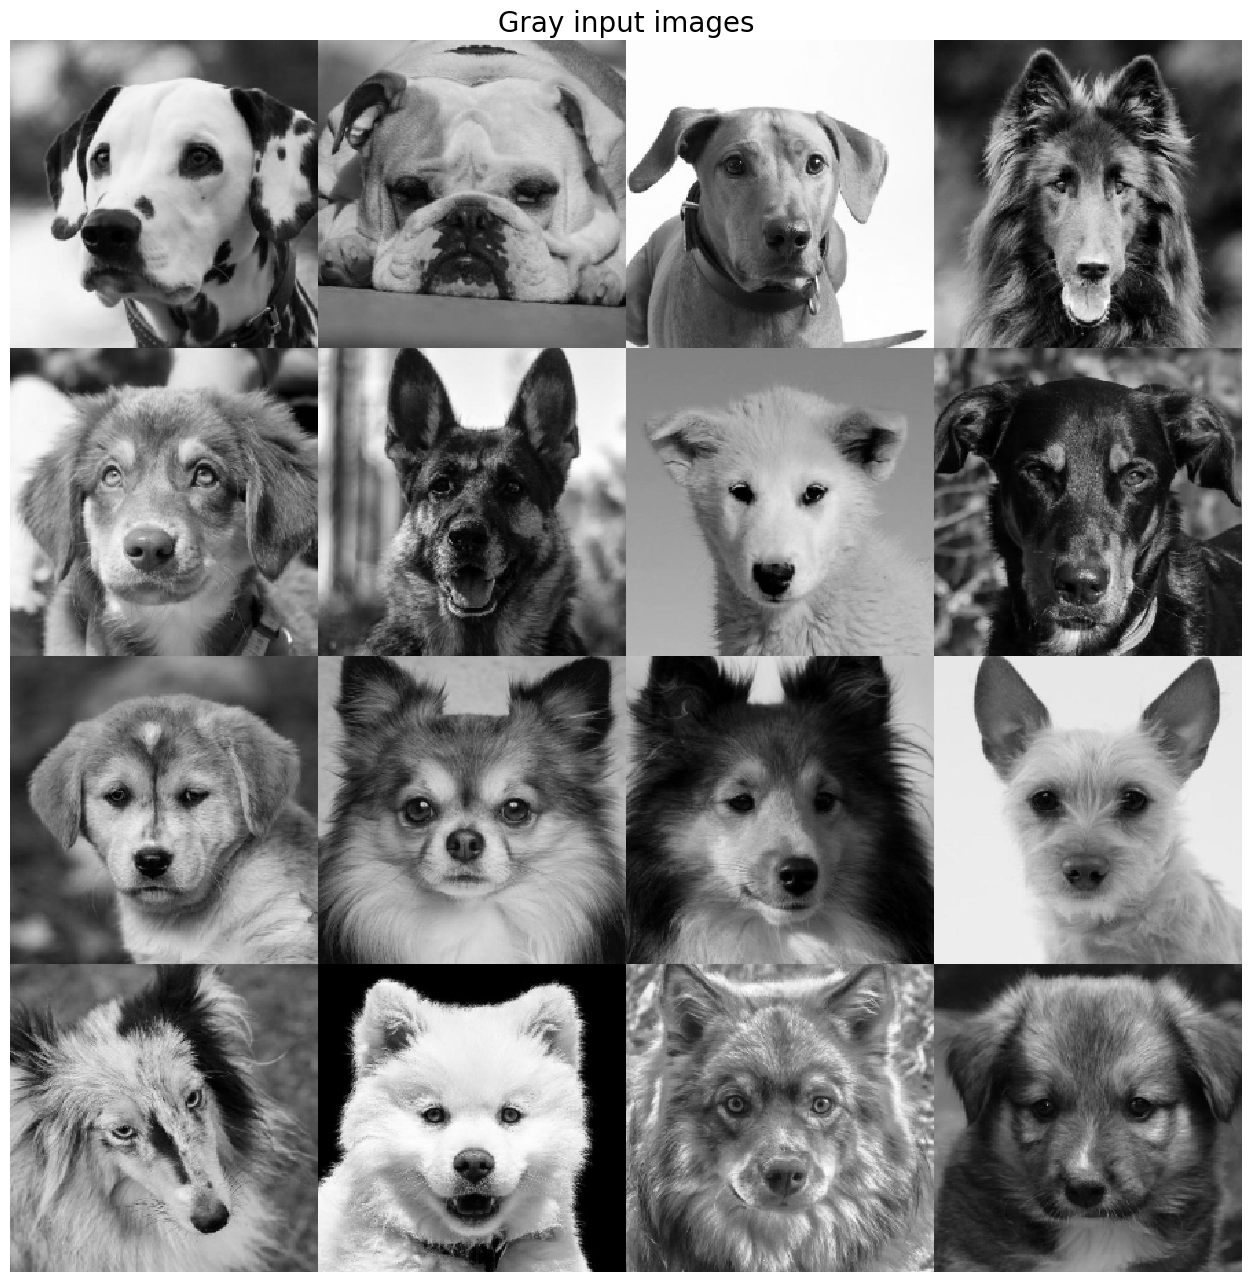

In [ ]:
imgs = x_test_gray[:16]
imgs = imgs.reshape((4, 4, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.title('Gray input images', fontsize=20)
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('Gray input images.png')
plt.show()

## Normalization of color images in the training and test sets

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

## Normalization of grayscale images in the training and test sets

In [ ]:
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

## Changing the shape of color images to row x column x channel

In [ ]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

## Changing the shape of gray images to row x column x channel

In [ ]:
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

## Network parameters

In [ ]:
input_shape = (img_rows, img_cols, 1)
batch_size = 8
kernel_size = 3
latent_dim = 256

## Number of CNN layers acting as encoders / decoders and number of filters per layer

In [ ]:
layer_filters = [64, 128, 256]

## Encoder construction

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ implicit_vector (Dense)         │ (None, 256)            │    51,380,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,750,144 (197.41 MB)

 Trainable params: 51,750,144 (197.41 MB)

 Non-trainable params: 0 (0.00 B)

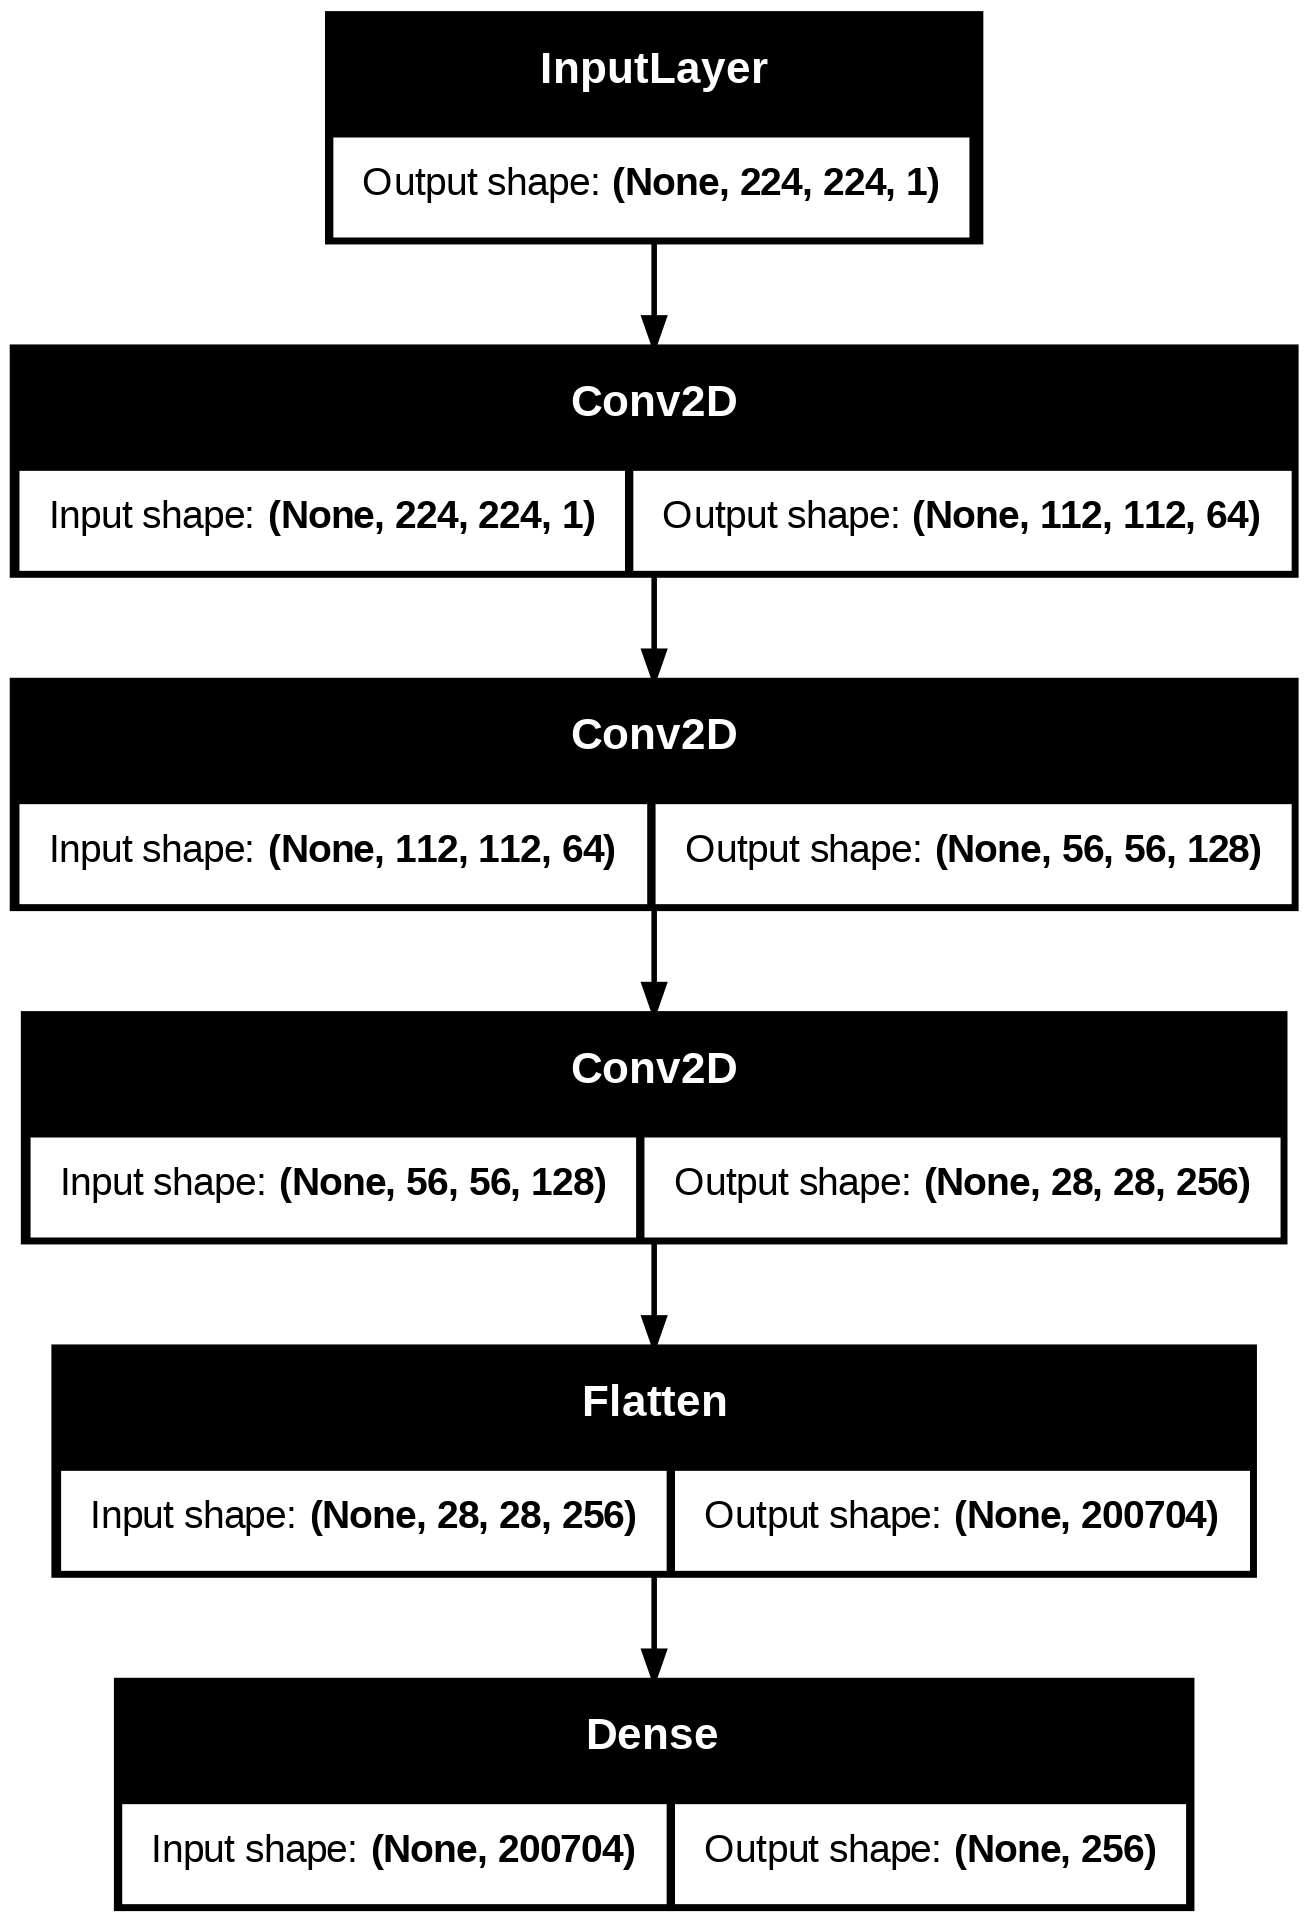

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Conv2D(32)-Conv2D(64) stack
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
shape = K.int_shape(x)

# Generating an implicit vector
x = Flatten()(x)
latent = Dense(latent_dim, name='implicit_vector')(x)

# Creating an encoder object
encoder = Model(inputs,
                latent,
                name='Encoder')
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200704)         │    51,580,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 56, 56, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 112, 112, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 224, 224, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 224, 224, 3)    │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,541,571 (200.43 MB)

 Trainable params: 52,541,571 (200.43 MB)

 Non-trainable params: 0 (0.00 B)

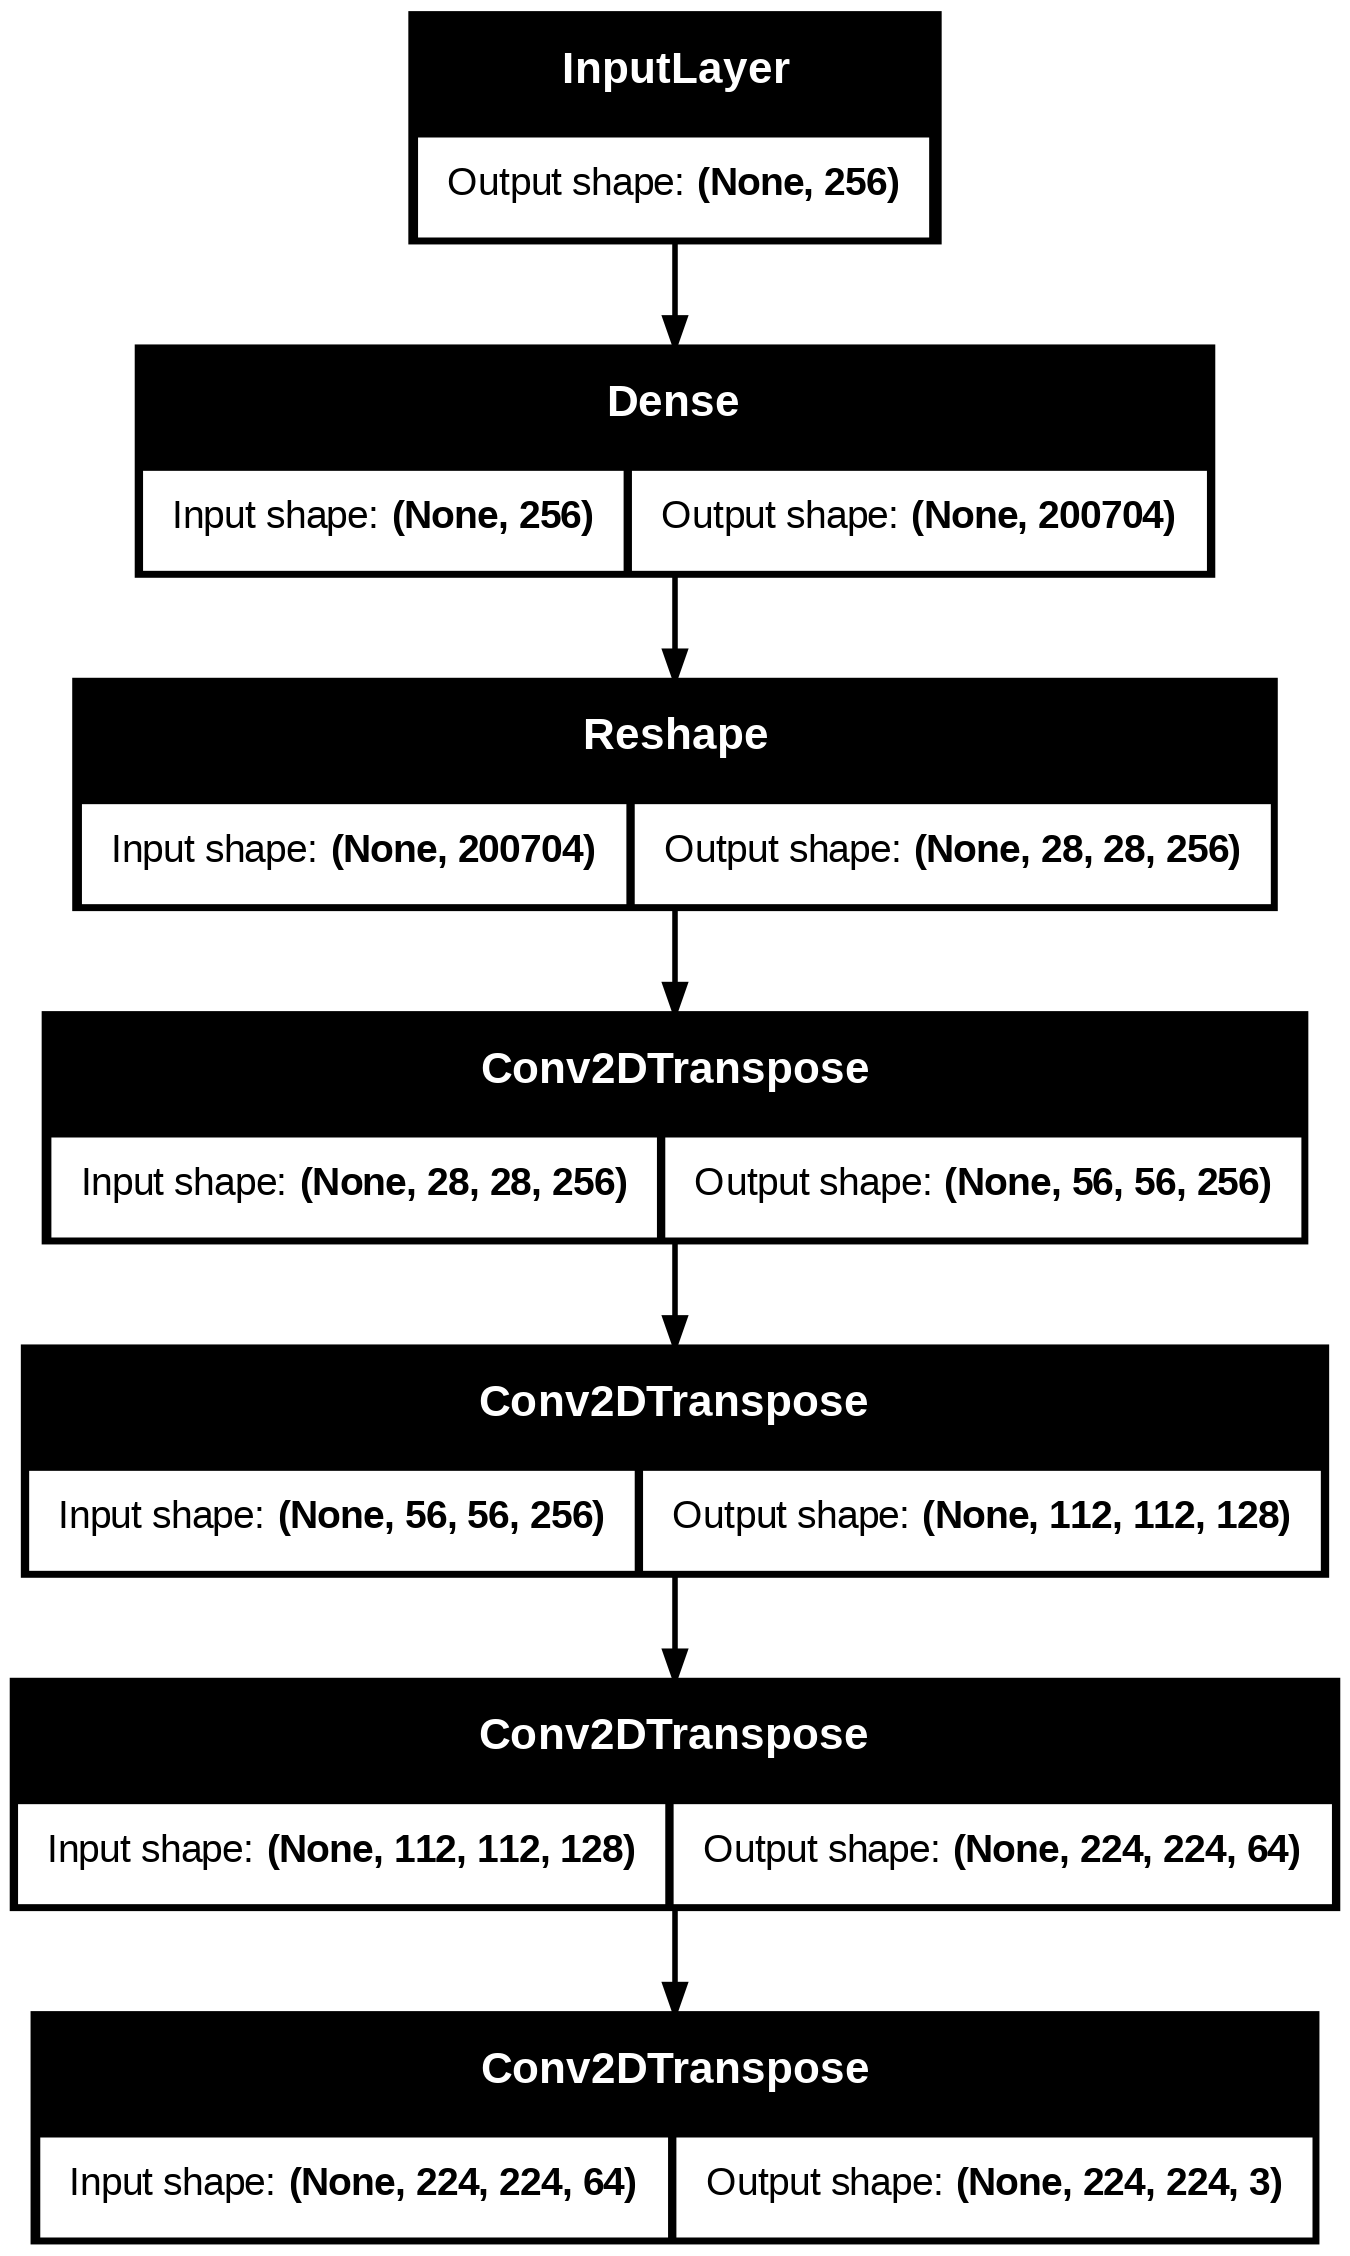

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)

# Changing the shape to a form suitable for Conv2D
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of layers Conv2DTranspose(256)-Conv2DTranspose(128)
# -Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# Reconstruction of input signals
outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# Creating a decoder object
decoder = Model(latent_inputs,
                outputs,
                name='Decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

## Decoder construction

## Autoencoder object = encoder + decoder

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, 256)            │    51,750,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 224, 224, 3)    │    52,541,571 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,291,715 (397.84 MB)

 Trainable params: 104,291,715 (397.84 MB)

 Non-trainable params: 0 (0.00 B)

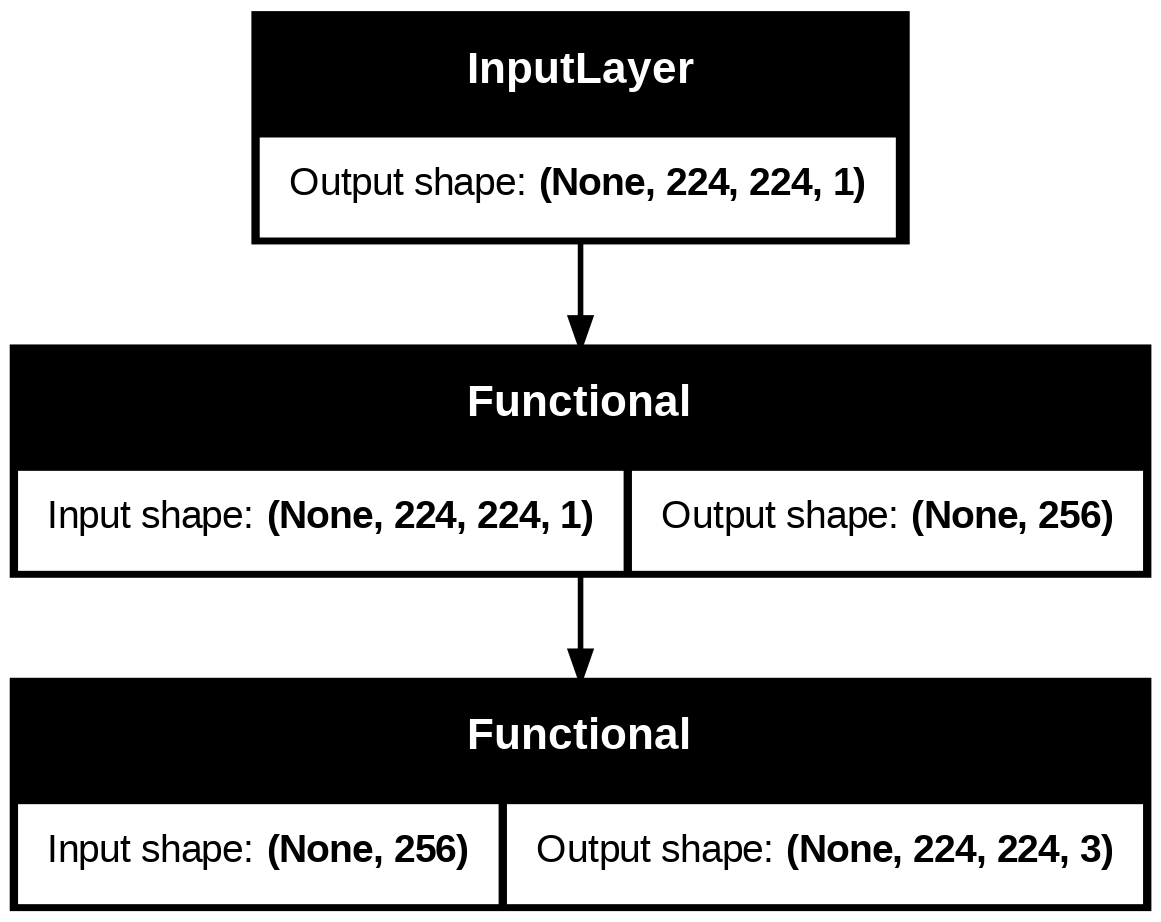

In [ ]:
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='Autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

## Loss function as mean square error (MSE) and Adam optimizer

In [ ]:
autoencoder.compile(loss='mse', optimizer='adam')

## Training an autoencoding network

In [ ]:
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=50,
                batch_size=batch_size)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 294ms/step - loss: 0.0695 - val_loss: 0.0570
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0458 - val_loss: 0.0404
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0357 - val_loss: 0.0355
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0316 - val_loss: 0.0334
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0283 - val_loss: 0.0308
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0259 - val_loss: 0.0296
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0239 - val_loss: 0.0283
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0223 - val_loss: 0.0273
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0207 - val_loss: 0.0272
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0191 - val_loss: 0.0265
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0180 - val_loss: 0.0268
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0

## Prediction of results for test data

In [ ]:
x_decoded = autoencoder.predict(x_test_gray)

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step


## Displaying the first 16 colored images

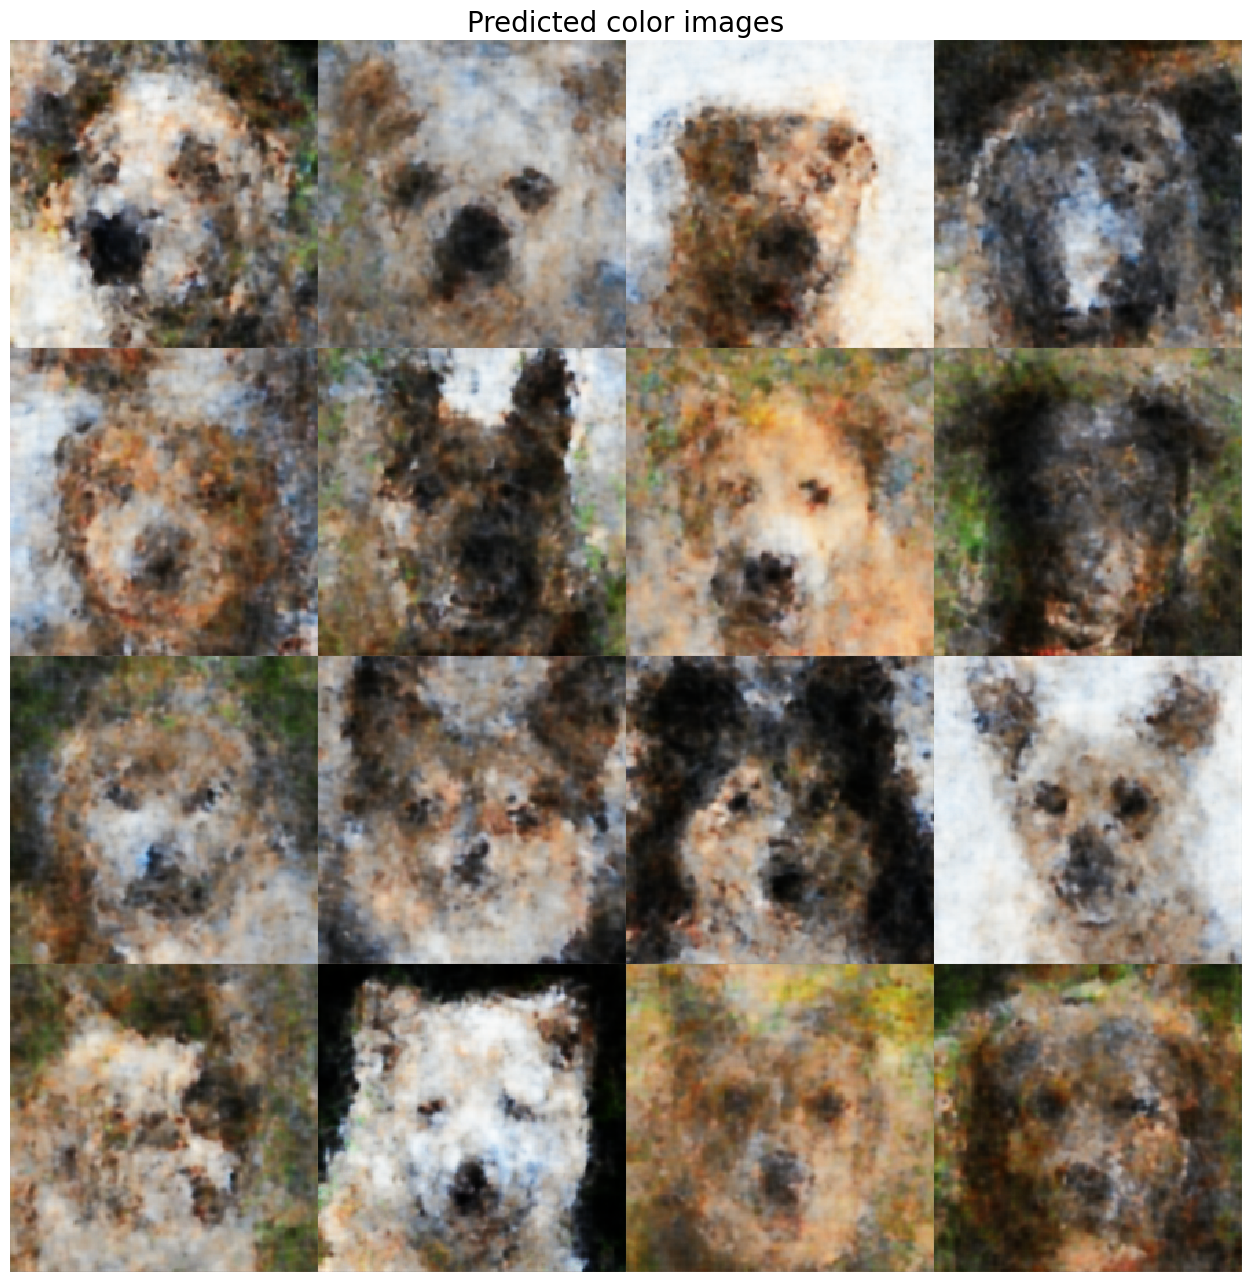

In [ ]:
imgs = x_decoded[:16]
imgs = imgs.reshape((4, 4, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.title('Predicted color images', fontsize=20)
plt.imshow(imgs, interpolation='none')
plt.savefig('Colored_images.png')
plt.show()

## Conclusions

The conclusions should justify the impact of:
- the specificity of the data collection;
- the number of training epochs (e.g., 50, 150)

on the results obtained.

Conclusions:
The results obtained from this colorization autoencoder experiment demonstrate a clear interplay between data collection specificity and training duration, with both factors critically influencing model performance. The use of a specialized dog dataset containing 500 training images and 50 test images at 224×224 resolution provided sufficient diversity for the model to learn meaningful color mappings from grayscale inputs, as evidenced by the training loss decreasing from 0.0695 to 0.0027 and validation loss stabilizing around 0.0284 after 50 epochs. However, the gap between training and validation loss, particularly in later epochs (training loss: 0.0027 vs. validation loss: 0.0284), suggests potential overfitting that could be mitigated with a larger, more diverse dataset or extended training with regularization techniques. Training for 50 epochs proved adequate for convergence, as loss values plateaued after approximately epoch 40, indicating that extending training to 150 epochs without additional regularization or data augmentation would likely yield diminishing returns and exacerbate overfitting. The specificity of focusing on a single animal category (dogs) enabled the network to specialize in capturing breed-specific color patterns and textures, but simultaneously limited its generalization capacity to other domains. Consequently, while 50 epochs with a focused dataset of 500 images achieved reasonable colorization results for this specific task, optimal performance would require either expanding the dataset to include greater intra-class variation or implementing transfer learning strategies if the model were to be applied to different animal categories or more heterogeneous image collections.